# Exercise 13 - Solution 

Use the SINDy algorthim as presented in the lecture on a Rössler system. The Rössler system is a three-dimensional chaotic dynamical system given by the governing equations: 
$$\frac{dx}{dt} = -y-z \\
\frac{dy}{dt} = x + ay \\ 
\frac{dz}{dt} = b + z(x - c),$$
with the most common parameter choices $a=0.1$, $b=0.1$, $c=14$. The Rössler system was set up by Otto Rössler to be a "minimal" chaotic system, as it is a three dimensional system with only nonlinearity. It was later found to be usefull for modelling certain chemical reactions as well. 

* Generate training data from the known Rössler system with `DifferentialEquations.jl` or `DynamicalSystems.jl`
* Use the training data for SINDy, to investigate if the algorithm can recover the governing equations correctly with the help of `DataDrivenDiffEq.jl` 
* How long, i.e. how much, training data do you need for the SINDy algorithm to sucussfully fit the Rössler equation? 

First, we are going to generate the training data. We'll integrate a very long trajectory

In [1]:
using Pkg
Pkg.activate(; temp = true)
Pkg.add(
    [
        "OrdinaryDiffEq", 
        "DataDrivenDiffEq", 
        "DataDrivenSparse", 
        "Flux", 
        "Zygote", 
        "Optimisers", 
        "SciMLSensitivity", 
        "SymbolicRegression",
        "Plots",
    ]
)

  Activating new project at `/tmp/jl_7Y03qu`
┌ Warning: could not download https://pkg.julialang.org/registries
│   exception = RequestError: Could not resolve host: pkg.julialang.org while requesting https://pkg.julialang.org/registries
└ @ Pkg.Registry ~/.julia/juliaup/julia-1.10.0+0.x64.linux.gnu/share/julia/stdlib/v1.10/Pkg/src/Registry/Registry.jl:69
   Resolving package versions...
    Updating `/tmp/jl_7Y03qu/Project.toml`
  [2445eb08] + DataDrivenDiffEq v1.3.0
  [5b588203] + DataDrivenSparse v0.1.2
  [587475ba] + Flux v0.14.11
  [3bd65402] + Optimisers v0.3.2
  [1dea7af3] + OrdinaryDiffEq v6.70.1
  [91a5bcdd] + Plots v1.40.1
  [1ed8b502] + SciMLSensitivity v7.55.0
  [8254be44] + SymbolicRegression v0.23.1
  [e88e6eb3] + Zygote v0.6.69
    Updating `/tmp/jl_7Y03qu/Manifest.toml`
  [47edcb42] + ADTypes v0.2.6
  [621f4979] + AbstractFFTs v1.5.0
  [1520ce14] + AbstractTrees v0.4.4
⌅ [79e6a3ab] + Adapt v3.7.2
  [dce04be8] + ArgCheck v2.3.0
  [ec485272] + ArnoldiMethod v0.2.0
  [4fba

  [189a3867] + Reexport v1.2.2
  [05181044] + RelocatableFolders v1.0.1
  [ae029012] + Requires v1.3.0
  [ae5879a3] + ResettableStacks v1.1.1
  [37e2e3b7] + ReverseDiff v1.15.1
  [79098fc4] + Rmath v0.7.1
  [7e49a35a] + RuntimeGeneratedFunctions v0.5.12
  [94e857df] + SIMDTypes v0.1.0
  [476501e8] + SLEEFPirates v0.6.42
  [0bca4576] + SciMLBase v2.23.1
  [c0aeaf25] + SciMLOperators v0.3.7
  [1ed8b502] + SciMLSensitivity v7.55.0
  [30f210dd] + ScientificTypesBase v3.0.0
  [6c6a2e73] + Scratch v1.2.1
  [efcf1570] + Setfield v1.1.1
  [605ecd9f] + ShowCases v0.1.0
  [992d4aef] + Showoff v1.0.3
  [777ac1f9] + SimpleBufferStream v1.1.0
  [727e6d20] + SimpleNonlinearSolve v1.3.2
  [699a6c99] + SimpleTraits v0.9.4
  [ce78b400] + SimpleUnPack v1.1.0
  [a2af1166] + SortingAlgorithms v1.2.1
  [47a9eef4] + SparseDiffTools v2.16.0
  [dc90abb0] + SparseInverseSubset v0.1.2
  [e56a9233] + Sparspak v0.3.9
  [276daf66] + SpecialFunctions v2.3.1
  [171d559e] + SplittablesBase v0.1.15
  [aedffcd0] + Stat

  [cf7118a7] + UUIDs
  [4ec0a83e] + Unicode
  [e66e0078] + CompilerSupportLibraries_jll v1.0.5+1
  [deac9b47] + LibCURL_jll v8.4.0+0
  [e37daf67] + LibGit2_jll v1.6.4+0
  [29816b5a] + LibSSH2_jll v1.11.0+1
  [c8ffd9c3] + MbedTLS_jll v2.28.2+1
  [14a3606d] + MozillaCACerts_jll v2023.1.10
  [4536629a] + OpenBLAS_jll v0.3.23+2
  [05823500] + OpenLibm_jll v0.8.1+2
  [efcefdf7] + PCRE2_jll v10.42.0+1
  [bea87d4a] + SuiteSparse_jll v7.2.1+1
  [83775a58] + Zlib_jll v1.2.13+1
  [8e850b90] + libblastrampoline_jll v5.8.0+1
  [8e850ede] + nghttp2_jll v1.52.0+1
  [3f19e933] + p7zip_jll v17.4.0+2
        Info Packages marked with ⌃ and ⌅ have new versions available. Those with ⌃ may be upgradable, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated -m`


In [2]:
using OrdinaryDiffEq, Plots

function roessler(u, p, t)
    a, b, c = p
    x, y, z = u
    return [-y - z, x + a * y, b + z * (x - c)]
end

p = [0.1, 0.1, 14.0]
x0 = rand(3)

prob = ODEProblem(roessler, x0, (0.0, 1000.0), p)
sol = solve(prob, Tsit5(), saveat = 0.1)

retcode: Success
Interpolation: 1st order linear
t: 10001-element Vector{Float64}:
    0.0
    0.1
    0.2
    0.3
    0.4
    0.5
    0.6
    0.7
    0.8
    0.9
    1.0
    1.1
    1.2
    ⋮
  998.9
  999.0
  999.1
  999.2
  999.3
  999.4
  999.5
  999.6
  999.7
  999.8
  999.9
 1000.0
u: 10001-element Vector{Vector{Float64}}:
 [0.5112425563153699, 0.07016605190349923, 0.9294286557557947]
 [0.45044486439089976, 0.11868637471980648, 0.2458376914985239]
 [0.42251730351906447, 0.16364224057736934, 0.06879603385325028]
 [0.3998932807170598, 0.2066144520495027, 0.02314466327766647]
 [0.37556346233321924, 0.24768520117845585, 0.011394916902247757]
 [0.3478763026850407, 0.2865603489529882, 0.00837062408710589]
 [0.3165928429584975, 0.32286285003406945, 0.0075837217061193165]
 [0.2818674418684084, 0.35621147490033356, 0.00736975278423346]
 [0.24398259559354005, 0.38624413854238243, 0.00730077218813805]
 [0.20327902825098088, 0.4126267109694248, 0.0072676403589049705]
 [0.1601352188687751, 0.

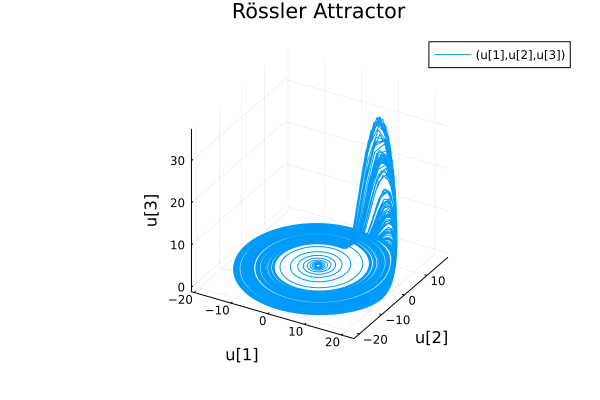

In [3]:
plot(sol, idxs = (1,2,3), title = "Rössler Attractor")

We see the typical shape of the Rössler attractor!

Now, let's use this data as training data for SINDy.

In [4]:
using DataDrivenDiffEq, DataDrivenSparse

function train_SINDy(prob, N_t, Δt = 0.1, Ttr = 10.0)
    t_saveat = Ttr:Δt:(Ttr+N_t*Δt)
    sol = solve(remake(prob; tspan = (0.0, t_saveat[end])), Tsit5(), saveat = t_saveat)
    
    ddprob = DataDrivenProblem(sol)
    
    @variables t x(t) y(t) z(t)  # Symbolic variables
    u = [x, y, z]
    basis = Basis(polynomial_basis(u, 5), u, iv = t)
     
    optimiser = STLSQ(exp10.(-5:0.1:-1))

    solve(ddprob, basis, optimiser, options = DataDrivenCommonOptions(digits = 2))
end 

train_SINDy (generic function with 3 methods)

Let's test it first with 5000 data points: 

In [5]:
sol = train_SINDy(prob, 10000)

"DataDrivenSolution{Float64}"

In [6]:
sol.basis

Model ##Basis#247 with 3 equations
States (3):
  x(t)
  y(t)
  z(t)
Parameters (7):
  p₁
  p₂
  p₃
  p₄
  p₅
  p₆
⋮

In [7]:
sol.prob.p

7-element Vector{Float64}:
  -1.0
  -0.99
   0.99
   0.1
   0.09
 -13.99
   1.0

So, for 5000 data points it works very well! We'll try to test when SINDy finds the right functional form by computing the fit for different values of $N_t$ and checking if we still return exactly seven parameters. Then we will inspect the actual parameter values around that point! 

In [8]:
for N_t = 500:-10:10 
    sol = train_SINDy(prob, N_t)
    
    if length(sol.prob.p) != 7 
        println("Parameter set not valid at N_t=", N_t)
        break
    end 
end 

Parameter set not valid at N_t=20


In [9]:
for N_t = 50:-1:10 
    sol = train_SINDy(prob, N_t)
    
    if length(sol.prob.p) != 7 
        println("Parameter set not valid at N_t=", N_t)
        break
    end 
end 

Parameter set not valid at N_t=26


In [14]:
sol = train_SINDy(prob, 27)
sol.basis

Model ##Basis#940 with 3 equations
States (3):
  x(t)
  y(t)
  z(t)
Parameters (7):
  p₁
  p₂
  p₃
  p₄
  p₅
  p₆
⋮

In [15]:
sol.prob.p

7-element Vector{Float64}:
  -1.0
  -1.0
   1.0
   0.1
   0.1
 -14.0
   1.0

In [16]:
sol = train_SINDy(prob, 26)
sol.basis

Model ##Basis#949 with 3 equations
States (3):
  x(t)
  y(t)
  z(t)
Parameters (32):
  p₁
  p₂
  p₃
  p₄
  p₅
  p₆
⋮

In [17]:
sol.prob.p

32-element Vector{Float64}:
 -1.0
 -1.0
  1.0
  0.1
  0.33
 -0.26
 -0.53
  1.79
 -1.47
  0.39
  0.27
 -0.58
 -0.45
  ⋮
  0.56
  2.56
 -8.93
 15.19
 -2.91
 -1.09
  7.71
 14.42
 -3.03
  5.08
 14.2
  2.51

So in this case, the SINDy algorithm is still able to find the rhs for 27 data points, but fails for 26. 